# Fama French Five Factor Model

In [1]:
import vectorbt as vbt
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import scipy.stats as stats
import plotly.graph_objects as go
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import getFamaFrenchFactors as fff
from sklearn.linear_model import LinearRegression

In [2]:
# list low volume stocks
# https://finviz.com/screener.ashx?v=111&f=exch_nasd,geo_usa,ipodate_more15&o=volume
# if we were doing more, I would set up API, but this is only 10 stocks
stocks_list = ['SPY', 'INTG', 'HFBL', 'SFBC', 'AIRT', 'EEA', 'CSD', 'GBLI', 'NXN', 'PFIN', 'LINK']
securities = vbt.YFData.download(symbols=stocks_list)
sectors = securities.data.keys()
# create a new column for each sector
df = pd.DataFrame()
for sector in sectors:
  df[sector] = securities.data[sector]['Close']
# make index tz-naive
df.index = df.index.tz_localize(None)
df = df.dropna()

/Users/johnboesen/Documents/Code/#Algotraders/yja/yja-env/lib/python3.9/site-packages/vectorbt/data/base.py:527: UserWarning: Symbols have mismatching index. Setting missing data points to NaN.
  data = cls.align_index(data, missing=missing_index)


In [10]:
fffdf = fff.famaFrench3Factor(frequency='m')
fffdf.columns

NameError: name 'plt' is not defined

In [14]:
fffdf.tail()

,date_ff_factors,Mkt-RF,SMB,HML,RF
1155,2022-10-31,0.0783,0.0009,0.0805,0.0023
1156,2022-11-30,0.0460,-0.0340,0.0138,0.0029
1157,2022-12-31,-0.0641,-0.0068,0.0132,0.0033
1158,2023-01-31,0.0665,0.0502,-0.0405,0.0035
1159,2023-02-28,-0.0258,0.0110,-0.0080,0.0034


In [12]:
import matplotlib.pyplot as plt
# take only dates after 2010-01-01
fffdf = fffdf[fffdf.index >= '2010-01-01']
plt.plot(fffdf['Mkt-RF'])

TypeError: Invalid comparison between dtype=int64 and str

In [32]:
df.dropna()

def calc_er(df, ticker, alpha=0.9):
    df = df.copy()
    ff3_monthly = fff.famaFrench3Factor(frequency='m')
    ff3_monthly.rename(columns={"date_ff_factors": 'Date'}, inplace=True)
    ff3_monthly.set_index('Date', inplace=True)
    ff3_monthly = ff3_monthly[ff3_monthly.index >= '2008-01-09 05:00:00']
    stock_returns = df[ticker].resample('M').last().pct_change().dropna()
    stock_returns = stock_returns.rename('monthly_returns')
    # join stock_returns and df on index so stock_returns is a column in df
    # print(stock_returns.head())
    # get all rows in stock_returns where keys aren't sorted
    df = pd.merge_asof(df.sort_values('Date'), stock_returns, left_on='Date', right_on='Date')
    # print(df.head())
    df['market_premium'] = [np.nan] * len(df)
    df['size_premium'] = [np.nan] * len(df)
    df['value_premium'] = [np.nan] * len(df)
    df['Mkt-RF'] = [np.nan] * len(df)
    df['RF'] = [np.nan] * len(df)
    df['y'] = df['monthly_returns'].interpolate(method='polynomial', order=3, axis=0).ffill().bfill()

    # print variance in ff3 columns
    
    # print(df.shape, stock_returns.shape, ff3_monthly.shape)
    L = len(df)
    for i in range(L):
        if i == 0 or i > 181:
            continue
        relevant_ff3 = ff3_monthly.iloc[:i + 1] if i + 1 != L else ff3_monthly
        df.loc[i, 'market_premium'] = relevant_ff3['Mkt-RF'].iloc[-1]
        df.loc[i, 'size_premium'] = relevant_ff3['SMB'].iloc[-1]
        # get the last element of the series
        df.loc[i, 'value_premium'] = relevant_ff3['HML'].iloc[-1]
        df.loc[i, 'Mkt-RF'] = relevant_ff3['Mkt-RF'].iloc[-1]
        df.loc[i, 'RF'] = relevant_ff3['RF'].iloc[-1]
        df.loc[i, 'y'] = df['monthly_returns'].iloc[i] - relevant_ff3['RF'][i]
    
    # fill in null rows of x with mean of next and previous nonnull values
    # df['market_premium'] = df['market_premium'].fillna(method='ewm')
    df['market_premium'] = df['market_premium'].interpolate(method='polynomial', order=3, axis=0).ffill().bfill()
    df['size_premium'] = df['size_premium'].interpolate(method='polynomial', order=3, axis=0).ffill().bfill()
    df['value_premium'] = df['value_premium'].interpolate(method='polynomial', order=3, axis=0).ffill().bfill()
    df['risk_prem'] = df['Mkt-RF'].fillna(df['Mkt-RF'].interpolate(method='polynomial', order=3, axis=0).ffill().bfill())
    df['risk-free'] = df['RF'].fillna(df['RF'].interpolate(method='polynomial', order=3, axis=0).ffill().bfill())
    df['y'] = df['y'].fillna(df['y'].interpolate(method='polynomial', order=3, axis=0).ffill().bfill())
    # get null values of x
    # print(X[X.notnull().any(axis=0)])
    # cut off dates before 2008-01-09 05:00:00
    print(df.columns)
    df = df[df.Date >= '2008-01-09 05:00:00']
    return df[['Date', 'market_premium', 'size_premium', 'value_premium', 'risk_prem', 'risk-free', 'y']]

intg = calc_er(df, 'INTG')

Index(['Date', 'SPY', 'INTG', 'HFBL', 'SFBC', 'AIRT', 'EEA', 'CSD', 'GBLI',
       'NXN', 'PFIN', 'LINK', 'monthly_returns', 'market_premium',
       'size_premium', 'value_premium', 'Mkt-RF', 'RF', 'y', 'risk_prem',
       'risk-free'],
      dtype='object')


In [29]:
intg.columns

Index(['Date', 'SPY', 'INTG', 'HFBL', 'SFBC', 'AIRT', 'EEA', 'CSD', 'GBLI',
       'NXN', 'PFIN', 'LINK', 'monthly_returns', 'market_premium',
       'size_premium', 'value_premium', 'Mkt-RF', 'RF', 'y'],
      dtype='object')

In [40]:
def get_coefs(df, ticker):
  y = df['y']
  X = df[['market_premium', 'size_premium', 'value_premium', 'risk_prem', 'risk-free']]
  X = sm.add_constant(X)
  # get all x rows with no null values
  print(X[X.notnull().any(axis=1)])
  ff_model = sm.OLS(y, X).fit()
  print(ff_model.params)
  predicted_y = ff_model.predict(X)

  # update the expected returns column with the latest prediction
  df[f'{ticker}_Expected_Rtn'] = predicted_y / 30
  return df
get_coefs(intg, 'INTG')

      const  market_premium  size_premium  value_premium  risk_prem  risk-free
0       1.0         -0.0309       -0.0043        -0.0084    -0.0309     0.0013
1       1.0         -0.0309       -0.0043        -0.0084    -0.0309     0.0013
2       1.0         -0.0093        0.0071         0.0030    -0.0093     0.0017
3       1.0          0.0460       -0.0165        -0.0104     0.0460     0.0018
4       1.0          0.0186        0.0300        -0.0149     0.0186     0.0018
...     ...             ...           ...            ...        ...        ...
3831    1.0         -0.0258        0.0110        -0.0080    -0.0258     0.0034
3832    1.0         -0.0258        0.0110        -0.0080    -0.0258     0.0034
3833    1.0         -0.0258        0.0110        -0.0080    -0.0258     0.0034
3834    1.0         -0.0258        0.0110        -0.0080    -0.0258     0.0034
3835    1.0         -0.0258        0.0110        -0.0080    -0.0258     0.0034

[3836 rows x 6 columns]
const            -0.006275


,Date,market_premium,size_premium,value_premium,risk_prem,risk-free,y,INTG_Expected_Rtn
0,2008-01-09 05:00:00,-0.0309,-0.0043,-0.0084,-0.0309,0.0013,-0.029917,-0.000080
1,2008-01-10 05:00:00,-0.0309,-0.0043,-0.0084,-0.0309,0.0013,-0.029737,-0.000080
2,2008-01-11 05:00:00,-0.0093,0.0071,0.0030,-0.0093,0.0017,-0.029579,0.000065
3,2008-01-14 05:00:00,0.0460,-0.0165,-0.0104,0.0460,0.0018,-0.029440,-0.000328
4,2008-01-15 05:00:00,0.0186,0.0300,-0.0149,0.0186,0.0018,-0.029321,0.000282
...,...,...,...,...,...,...,...,...
3831,2023-03-29 04:00:00,-0.0258,0.0110,-0.0080,-0.0258,0.0034,-0.013918,0.000302
3832,2023-03-30 04:00:00,-0.0258,0.0110,-0.0080,-0.0258,0.0034,-0.013918,0.000302
3833,2023-03-31 04:00:00,-0.0258,0.0110,-0.0080,-0.0258,0.0034,0.072689,0.000302
3834,2023-04-03 04:00:00,-0.0258,0.0110,-0.0080,-0.0258,0.0034,0.072689,0.000302


<AxesSubplot: xlabel='Date'>

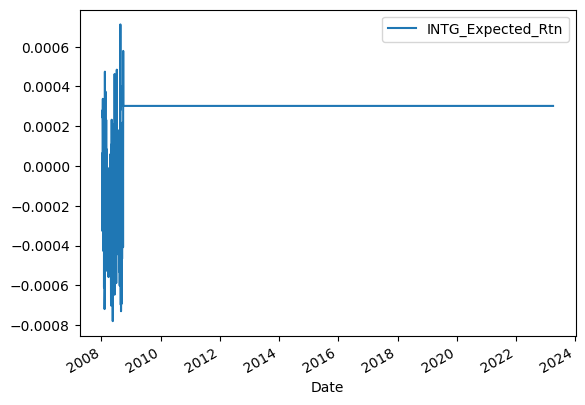

In [41]:
intg.plot('Date', ['INTG_Expected_Rtn'], kind='line')

In [6]:
df.head()

,SPY,INTG,HFBL,SFBC,AIRT,EEA,CSD,GBLI,NXN,PFIN,LINK
Date,,,,,,,,,,,
2008-01-09 05:00:00,104.165733,18.290001,3.482935,7.326815,4.819349,6.789409,20.534878,33.486565,7.258776,4.613729,7.2
2008-01-10 05:00:00,104.848396,18.290001,3.482935,7.693157,4.841609,6.795183,20.927046,33.221970,7.355060,4.697616,7.4
2008-01-11 05:00:00,104.002480,18.290001,3.482935,7.693157,4.952910,6.673944,20.334618,31.750219,7.323389,5.318371,7.4
2008-01-14 05:00:00,104.841019,17.910000,3.486602,7.326815,4.980737,6.714358,20.534878,32.477829,7.366335,5.452589,7.4
2008-01-15 05:00:00,102.533112,18.020000,3.482935,7.326815,4.925086,6.518065,20.017540,32.725868,7.355598,5.536476,7.2


                     market_premium  size_premium  value_premium
Date                                                            
2008-01-09 05:00:00       -0.000415     -0.000329      -0.000248
2008-01-10 05:00:00       -0.000415     -0.000329      -0.000248
2008-01-11 05:00:00       -0.000415     -0.000329      -0.000248
2008-01-14 05:00:00       -0.000415     -0.000329      -0.000248
2008-01-15 05:00:00       -0.000415     -0.000329      -0.000248
...                             ...           ...            ...
2022-09-30 00:00:00   -64373.502039  -4801.646077   56507.554871
2022-10-31 00:00:00   -15731.805664  -4242.546115  106515.940115
2022-11-30 00:00:00    16019.549907 -27710.939369  116041.346890
2022-12-31 00:00:00   -33141.365588 -32926.137890  126164.967651
2023-01-31 00:00:00    23527.049861   9937.340233   91396.977577

[4009 rows x 3 columns]
                                 OLS Regression Results                                
Dep. Variable:                      y   R-

Date
2008-01-09 05:00:00    0.001300
2008-01-10 05:00:00    0.001300
2008-01-11 05:00:00    0.001300
2008-01-14 05:00:00    0.001300
2008-01-15 05:00:00    0.001300
                         ...   
2022-09-30 00:00:00   -0.047138
2022-10-31 00:00:00   -0.011061
2022-11-30 00:00:00   -0.018740
2022-12-31 00:00:00   -0.058726
2023-01-31 00:00:00    0.035185
Length: 4009, dtype: float64

<AxesSubplot: xlabel='Date'>

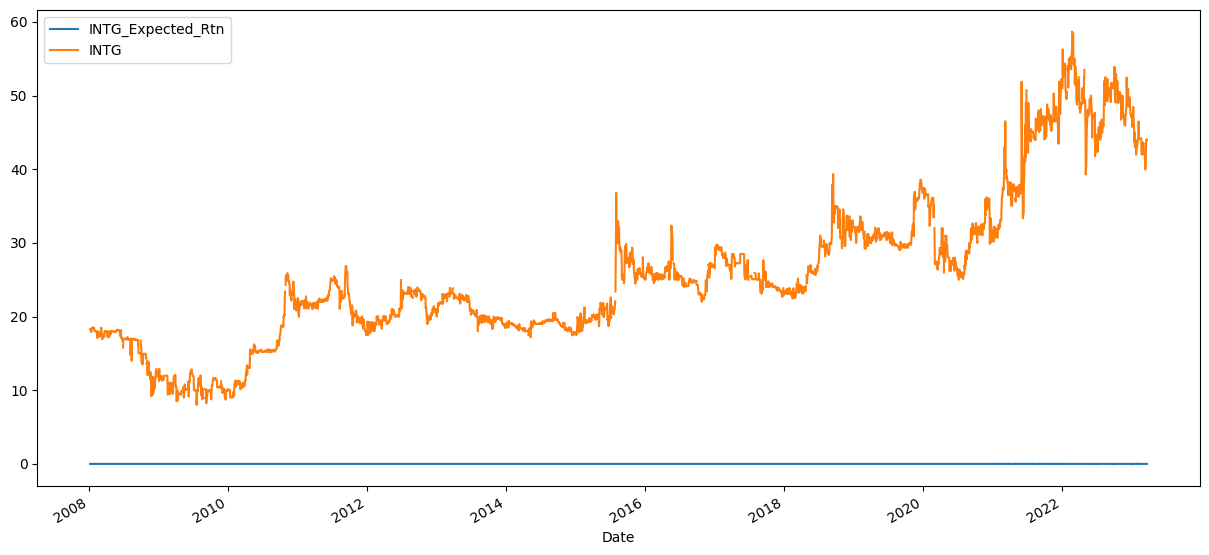

In [20]:
# plot expected returns versus actual returns
df[['INTG_Expected_Rtn', 'INTG']].plot(figsize=(15, 7))